# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №5 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 декабря 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 декабря, -4 балла после 06:00 24 декабря, -6 баллов после 06:00 31 декабря -8 баллов  после 06:00 7 января


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (6 баллов)

###### Боевое применение (2 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

# Определяем, что вам досталось

Укажите свою фамилию на русском языке в поле ниже.

In [3]:
import hashlib

def lucky_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16) 

USER_NAME = u"Tерёхина".lower()

ALGORITHMS = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)",]

print ("Имплементируйте алгоритм кластеризации %s"\
% (
    ALGORITHMS[lucky_hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте алгоритм кластеризации Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)


Не стоит переживать из-за Вашего варианта. Технически оба алгоритма несложно реализовать.  EM алгоритма бояться не стоит, Вам будет нужно просто реализовать уже выведенные формулы для E и M шагов.

In [4]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать один из двух популярных методов кластеризации: разделение смеси нормальных распределений или агломеративную кластеризацию. 

## Смесь нормальных распределений



Предполагаем, что наши данные порождены смесью $k$ нормальных распределений, то есть 

$$ p(\mathbf{x}) = \sum_k \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k) $$,


где $\mathcal{N}$ - многомерное нормальное распределение размерности ${D}$:

$$\mathcal{N(\mathbf{x} | \mathbf{\mu}, \mathbf{\Sigma}}) = \frac{1}{(2 \pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma^{-1}} (\mathbf{x} - \mathbf{\mu})\right\}$$

**Параметры**  


${D}$-мерный вектор средних

$$\mathbf{\mu}$$

$D \times D$-мерная матрица ковариации   (симметричная)


$$\mathbf{\Sigma} = E[(\mathbf{x} - \mathbf{\mu})(\mathbf{x} - \mathbf{\mu})^T]$$



Необходимо оценить параметры $\pi_k, \mathbf{\mu_k}, \mathbf{\Sigma_k} $ для всех компонент смеси.  Сделать это можно с помощью EM алгоритма - алгоритма, который находит оценку максимального правдоподобия в задаче со скрытыми переменными. 

## Expectation Maximization

**I** До цикла проинциализировать случайно  $\mu_k, \Sigma_k, \pi_k$ ($\pi_k$ должны суммироваться в 1)

**E** 

Expectation: при фиксированных $\mu_k, \Sigma_k, \pi_k$
$$
p(z_k = 1| x_n ) = \gamma(z_{nk}) = \frac{\pi_k \mathcal{N} (\mathbf{x}_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N} (\mathbf{x}_n | \mu_j, \Sigma_j)}
$$
**M** 

Maximization: при фиксированных $\gamma(z_{nk})$
$$
N_k = \sum_{n=1}^N \gamma(z_{nk}), \;\; \mu_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$
$$
\Sigma_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^T
$$
$$
\pi_k = \frac{N_k}{N}
$$
**S** Остановиться при достижении сходимости

Номер кластера для $n$ объекта будем брать по принципу maximum a-posteriori, то есть относить объект к тому кластеру, у которого максимальна апостериорная вероятность:
$$ k_n =  \arg\underset{k}\max  p(z_k = 1| x_n ) =  \arg\underset{k}\max \gamma(z_{nk}) $$

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Для простоты будем использовать евклидово расстояние между объектами.



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

Функционал, минимизирующий kmeans: 
$$ L(C) = \sum_{k=1}^K\sum_{i\in C_k} ||x_i - \mu_k||^2 \rightarrow \min\limits_C $$
$$ \mu_k = \frac{1}{|C_k|} \sum _{x_n \in C_k} x_n $$

E шаг: определение кластеров для точек
$$C_k = \{x_n : ||x_n - \mu_k||^2 \leq ||x_n - \mu_l||^2 \quad \forall l \neq k \} $$

На этом шаге центроиды фиксированы и кластеры для точек определяются, исходя из их близости к центроидам. В обоих случаях, как когда уже произошел M шаг, так и когда центроиды были выбраны случайно при инициализации, функционал не увеличивается.

M шаг: пересчет и обновление центроидов
$$ \mu_k = \frac{1}{|C_k|} \sum _{x_n \in C_k} x_n $$
На этом шаге фиксированы кластеры для всех точек и уже центроиды пересчитываются, исходя из положений (расстояний) точек кластера относительно центра. На этом шаге функционал тоже не может увеличиться.

Так как функционал не может увеличиться ни на E шаге, ни на М шаге, функционал не увеличивается на протяжении работы всего алгоритма.

Так же можно сказать, что функционал ограничен, исходя из того, что на некотором M шаге никакой из центроидов не обновится или они обновятся на незначительную (заранее заданную) величину.

Так как каждый объект мы можем отнести к одному из $k$ кластеров, объектов у нас $N$, а функционал не увеличивается и ограничен, то количество итераций не будет превышать $k^N$ -- ситуации, когда в работе алгоритма мы попытаемся отнести каждый возможный объект в каждый возможный кластер.



Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ваше решение здесь***

Правдоподобие должно быть ограничено

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

Используя соотношения на минимум и максимум для чисел имеем:

$d_{\min}(U \cup V, S) = \min(d_{\min}(U, S), d_{\min}(V, S)) = \min(A, B) = \frac{1}{2}(A + B - |A-B|)$
$d_{\max}(U \cup V, S) = \max(d_{\max}(U, S), d_{\max}(V, S)) = \max(A, B) = \frac{1}{2}(A + B + |A-B|)$

После подстановки обратно вместо $A \rightarrow d_{\min}(U, S)$ (для максимума $d_{\max}(U, S)$), вместо $B \rightarrow d_{\min}(V, S)$ (для максимума $d_{\max}(V, S)$) получаем искомые соотношения.

# Реализация алгоритма кластеризации  (6 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [108]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import euclidean_distances as ED
from itertools import combinations

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, k = 2, linkage='single', **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.k = k
        self.linkage = linkage
        if linkage == 'single':
            self.cluster_distance = self.single_linkage
        elif linkage == 'complete':
            self.cluster_distance = self.complete_linkage
        elif linkage == 'average':
            self.cluster_distance = self.average_linkage
        else:
            raise ValueError('Not supported type of linkage')
        
        self.clusters = None
        return
    
    def single_linkage(self, c_1, c_2):
        return np.min(self.distances[c_1].T[c_2])
    
    def complete_linkage(self, c_1, c_2):
        return np.max(self.distances[c_1].T[c_2])
    
    def average_linkage(self, c_1, c_2):
        return np.sum(self.distances[c_1].T[c_2])/(len(c_1) * len(c_2))
        
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.x_len = len(x)
        self.distances = ED(x)
        self.clusters = [[x] for x in range(self.x_len)]
        
        while len(self.clusters) > self.k:
            c_1, c_2 = self.clusters[0], self.clusters[1]
            distance = self.cluster_distance(c_1, c_2)
            for tmp_c_1, tmp_c_2 in combinations(self.clusters, 2):
                tmp_distance = self.cluster_distance(tmp_c_1, tmp_c_2)
                if tmp_distance < distance:
                    c_1, c_2, distance = tmp_c_1, tmp_c_2, tmp_distance
            self.clusters.remove(c_1)
            self.clusters.remove(c_2)
            self.clusters.append(c_1 + c_2)
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """

        labels = np.ones(self.x_len, dtype=int)
        for cl_num, x_ind in enumerate(self.clusters):
            labels[x_ind] = cl_num
        return labels
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

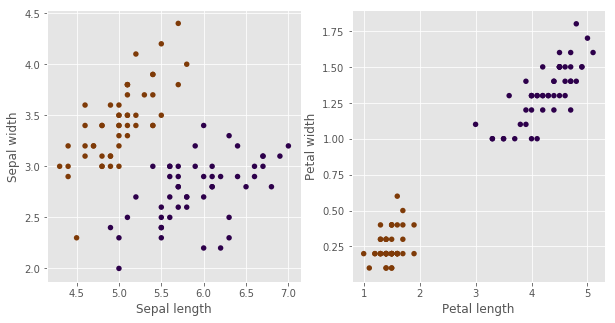

In [109]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [128]:
my_aggl = Clustering()
aggl_t0 = time.time()
my_aggl_pred = my_aggl.fit_predict(x_iris)
my_aggl_diff = time.time() - aggl_t0
my_aggl_score = smt.adjusted_rand_score(y_iris, my_aggl_pred)

print ("Adjusted Rand index for iris is: %.1f" % my_aggl_score)
print ("Time for iris is: %.2f" % my_aggl_diff)

Adjusted Rand index for iris is: 1.0
Time for iris is: 2.80


In [129]:
# Давайте проверим, как справляются sklearn реализации
sklearn_gmm = GaussianMixture(n_components=2)
gmm_t0 = time.time()
sklearn_gmm.fit(x_iris)
gmm_diff = time.time() - gmm_t0
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))

sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)

# print ("GMM score {}. GMM time {}. AGGL score {}. AGGL time {}".format(gmm_score, gmm_diff, aggl_score, aggl_diff))
print ("AGGL score {}. AGGL time {}".format(gmm_score, gmm_diff, aggl_score, aggl_diff))

AGGL score 1.0. AGGL time 0.006826162338256836


Сверьте Ваш алгоритм с этими числами. Уверен, что у Вас получится не хуже!

# Боевое применение (2  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для анализа реальной задачи!

Важное замечание: в этой части задания студенту самому предлагается разобраться с данными и их форматом в качестве полезного упраженения. Не принимайте это близко к сердцу :)

Ввозьмем датасет различных стран.  
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   


Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам. 
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   

Необходимо показать, какие страны попали в общий кластер в и объяснить из-за каких признаков это произошло. Если страны были в одном кластере, а спустя несколько лет разъехались по разным кластерам, попробуйте это объяснить. 

In [169]:
# Место для Вашего кластерного анализа
df = pd.read_csv('WDIData.csv')
print(df.shape)
df.head()

(422400, 63)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Arab World,ARB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"2005 PPP conversion factor, private consumptio...",PA.NUS.PRVT.PP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,81.844982,82.407647,82.827636,83.169227,83.587141,83.954293,84.230630,84.570425,NaN,NaN
3,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,85.189815,86.136134,86.782683,87.288244,88.389705,88.076774,88.517967,88.768654,NaN,NaN
4,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,73.530494,74.543489,75.770972,76.772916,78.839139,77.487377,78.564439,78.958780,NaN,NaN


In [170]:
df.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', 'Unnamed: 62'],
      dtype='object')

In [171]:
df.drop(['Country Code', 'Indicator Code', 'Unnamed: 62'], inplace=True, axis=1)
df.head()

,Country Name,Indicator Name,1960,1961,1962,1963,1964,1965,1966,1967,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Arab World,"2005 PPP conversion factor, GDP (LCU per inter...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,"2005 PPP conversion factor, private consumptio...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,Access to clean fuels and technologies for coo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.243897,81.844982,82.407647,82.827636,83.169227,83.587141,83.954293,84.230630,84.570425,NaN
3,Arab World,Access to electricity (% of population),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85.432827,85.189815,86.136134,86.782683,87.288244,88.389705,88.076774,88.517967,88.768654,NaN
4,Arab World,"Access to electricity, rural (% of rural popul...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.402277,73.530494,74.543489,75.770972,76.772916,78.839139,77.487377,78.564439,78.958780,NaN


In [172]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
encoder = LabelEncoder()

countries_map, indicators_map будут хранить соответствие закодированным названиям стран и индикаторов соответственно

In [173]:
df['Country Name'] = encoder.fit_transform(df['Country Name'])
countries_map = list(encoder.classes_)
len(countries_map)

264

In [174]:
df['Indicator Name'] = encoder.fit_transform(df['Indicator Name'])
indicators_map = list(encoder.classes_)
len(indicators_map)

1600

In [175]:
df.head()

,Country Name,Indicator Name,1960,1961,1962,1963,1964,1965,1966,1967,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.243897,81.844982,82.407647,82.827636,83.169227,83.587141,83.954293,84.230630,84.570425,NaN
3,7,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,85.432827,85.189815,86.136134,86.782683,87.288244,88.389705,88.076774,88.517967,88.768654,NaN
4,7,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.402277,73.530494,74.543489,75.770972,76.772916,78.839139,77.487377,78.564439,78.958780,NaN


In [247]:
df_tmp = df.copy()

Для каждого года разобью страны по кластерам исходя из их индикаторов, рассмотрю максимальные по модулю средние значения индикаторов для кластеров (вероятно, они должны что-то сказать о природе разделения на кластеры).

In [308]:
def clusterize_and_print_year_info(k=5, top_indicators_to_print=3, year = '1960'):
    print("Chosen k:", k)

    year_df = pd.DataFrame()
    year_df['country'] = df_tmp['Country Name']
    year_df['indicator'] = df_tmp['Indicator Name']
    year_df[year] = df_tmp[year]
    year_df.fillna(0, inplace=True)

    indicators_by_countries = np.ones((264, 1600))

    for c_ind in range(264):
        indicators_by_countries[c_ind] = year_df[year_df.country == c_ind][year]

    indicators_by_countries = scaler.fit_transform(indicators_by_countries)
    
    clusters = Clustering(k=k).fit_predict(indicators_by_countries)

    countries = {}
    indicators = {}
    # k clusters for countries and indicators
    for i in range(k):
        countries[i] = []
        indicators[i] = []


    for i, cl_num in enumerate(clusters):
        countries[cl_num].append(countries_map[i])
        indicators[cl_num].append(indicators_by_countries[i])

    print(year)

    for k_num in range(k):
        print("*"*100)
        print('Cluster:', k_num)
        print(len(countries[k_num]), countries[k_num])

        ind_dict = {}
        mean = np.mean(indicators[k_num], axis=0)

        # reverse maping to indicators names
        for ind, name in enumerate(indicators_map):
            if mean[ind] == 0:
                continue
            ind_dict[name] = mean[ind]

        # sort by abs mean value
        sorted(ind_dict, key=lambda name: abs(ind_dict[name]), reverse=True)
        print()
        iterator = iter(ind_dict.items())
        for i in range(top_indicators_to_print):
            print(next(iterator))

    print("="*100)

Посмотрим, что можно понять при делении на 10 кластеров. Рассмотрю 3 года (1960, 1988, 2017) с +- равными промежутками между друг другом. 3 потому что рассмотрение большего количества лет становится не особо читабельным и долгим по вычислениям.

In [311]:
clusterize_and_print_year_info(k=10, top_indicators_to_print=5, year = '1960')
clusterize_and_print_year_info(k=10, top_indicators_to_print=5, year = '1988')
clusterize_and_print_year_info(k=10, top_indicators_to_print=5, year = '2017')

Chosen k: 10
1960
****************************************************************************************************
Cluster: 0
1 ['Canada']

('Adjusted savings: particulate emission damage (current US$)', -0.6161885119103697)
('Adults (ages 15+) newly infected with HIV', -0.020289833822105485)
('Age dependency ratio (% of working-age population)', 1.3358310233254116)
('Age dependency ratio, old (% of working-age population)', -0.23423875537032718)
('Agricultural raw materials imports (% of merchandise imports)', -0.4305528342213994)
****************************************************************************************************
Cluster: 1
1 ['Indonesia']

('Adjusted savings: particulate emission damage (current US$)', 0.8732307669192848)
('Adults (ages 15+) newly infected with HIV', 0.20577878800552105)
('Age dependency ratio (% of working-age population)', -0.2465816400724574)
('Age dependency ratio, old (% of working-age population)', 0.25358706243085744)
('Agricultural raw ma

1988
****************************************************************************************************
Cluster: 0
1 ['Indonesia']

('Adequacy of unemployment benefits and ALMP (% of total welfare of beneficiary households)', 1.5846535405142217)
('Adjusted net enrollment rate, primary (% of primary school age children)', -0.6934591870565536)
('Adjusted net enrollment rate, primary, female (% of primary school age children)', -0.7176370900635053)
('Adjusted net enrollment rate, primary, male (% of primary school age children)', -5.739741928659036)
('Adjusted net national income (annual % growth)', -0.06952837636021313)
****************************************************************************************************
Cluster: 1
1 ['Iran, Islamic Rep.']

('Adequacy of unemployment benefits and ALMP (% of total welfare of beneficiary households)', 1.2890764346159342)
('Adjusted net enrollment rate, primary (% of primary school age children)', 1.4392086566688433)
('Adjusted net enrollme

2017
****************************************************************************************************
Cluster: 0
1 ['Indonesia']

('Access to electricity, urban (% of urban population)', 0.28662148278493027)
('Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+)', 0.42349703402548927)
('Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)', 0.14952360262892248)
('Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)', 0.2488407190980114)
('Account ownership at a financial institution or with a mobile-money-service provider, older adults (% of population ages 25+)', 0.08727922792911348)
****************************************************************************************************
Cluster: 1
1 ['Iran, Islamic Rep.']

('Access to electricity, urban (% of urban population)', 1.5374501787149146

Определенно можно видеть, что country_name содержал в себе не только названия стран но и некоторые общие категории типа World, Upper Income, которые имеют тенденцию отделяться в отдельные кластеры

А вообще деление на кластеры происходит исходя из некоторой оценки жизни в той или иной стране, включая, как факторы болезней (в 1960 году часто встречается показатель Adults (ages 15+) newly infected with HIV, как для благополучных стран вроде Канады, или не очень благополучных вроде стран Африки), ВВП (актуально для 1988 года), процента детей и женщин, получающих образование, а для 2017 года процент женщин, мужчин и взрослых людей, которые владеют аккаунтами в финансовых учереждениях и наличие доступа к электричеству.

Так же стоит сказать, что в моей реализации для 10 кластеров, для этих 3 лет, имеют тенденцию отделяться единичные объекты, и всегда существует один кластер, включающий в себя оставшиеся >250 объектов.



# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваше ответ здесь***

Я бы стала использовать их для задач без учителя, в которых мне не известна природа данных и/или необходимо определить некоторые признаки схожести или различия между объектами

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваше ответ здесь***

kmeans:
   * Прост в реализации
   * Позволяет интерпретировать кластеры через центроиды
   * Имеет много модификаций
   * Нужно задавать заранее количество кластеров
   * Кластеры имеют сферическую форму
   
dbscan:
   * Сам определяет количество кластеров
   * Кластеры могут иметь любую форму
   * Требует постоянную плотность в данных
   
агломеративная кластеризация:
   * Может разбивать на произвольное число кластеров после построения
   * Наглядность в виде дендрограммы
   * Имеет тенденцию к выделению очень мелких кластеров


* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваше ответ здесь***

Очевидным было бы сказать, что когда правдободобие не ограничено. В EM алгоритме мы предполагаем, что наше распределение является смесью нормальных и содержит некоторые скрытые переменные. Думаю, ограничения на применимость алгоритма лежат в выполенении этих предположений.

* Многие алгоритмы анализа данных страдают "проклятием" размерности. Страдают ли этим проклятием алгоритмы кластеризации? Если да, то как бы Вы с этим боролись?

Страдают. Боролась бы, например, удалением фичей, PCA.

***Ваше ответ здесь***

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваше ответ здесь***

Попытаться кластеризовать документы, если получится выделить кластеры, и их сможно будет проинтерпретировать, то можно неплохо урезать количество фичей, которые влияют на отнесение документа к той или иной тематике.

Если кластеризовать не получилось, то использовать стандартные подходы типа мешка слов + tf-idf на монограммах и биграммах. Размерность будет большая, с чем можно бороться ограничением на количество рассматриваемых токенов или "на глаз", если это возможно. Ну или не сильно бороться, а научиться работать с sparse данными.

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваше ответ здесь***

Думаю, это бы помогло решить проблему просмотра "на глаз" и выделения адекватных токенов/биграмм для отдельных тематик. Эти данные можно было бы использовать в виде дополнительных фич к кластеризации.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***